In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

# Load Pre-Processed Data

In [2]:
# set prediction target
target = 'ct_sales'

In [3]:
# load data for macro-level explainer
reigion_data = "denver_data.csv"
df = pd.read_csv(reigion_data)
df = df.dropna()
df.head()

,month,ct_listings,ct_sales,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,selling a house,...,demand_score,ldpviews_per_property_vs_us,MORTGAGE15US,MORTGAGE30US,MORTGAGE5US,unemployment_rate,avg_hour_salary,avg_week_salary,building_permits,building_permits_1unit
4,2016-07,8170,6408,61.815081,95.738568,84.635856,40.320925,4.728896,18.482621,61.552086,...,91.638796,1.7500,2.7475,3.440,2.7500,3.1,28.895241,1002.485800,1557.790154,874.314620
5,2016-08,7697,6614,49.269667,55.532880,63.621405,82.316527,4.496565,16.339958,63.038638,...,91.638796,1.7447,2.7450,3.435,2.7450,3.0,28.811627,1000.055202,1494.700070,913.006712
6,2016-09,6950,6109,38.933788,24.458258,42.838747,43.324917,8.171971,22.679009,42.922750,...,93.311037,1.7955,2.7560,3.460,2.8140,2.9,28.719960,995.203511,1930.650955,906.829652
7,2016-10,5371,5599,28.381404,25.461185,39.078552,57.093753,3.720349,11.200653,16.765770,...,94.314381,1.8372,2.7625,3.470,2.8275,2.8,29.187290,1031.379077,2442.475902,922.795686
8,2016-11,3966,5302,6.636020,14.200746,12.197739,26.952839,0.147016,0.000000,20.725690,...,95.652174,1.9524,3.0275,3.770,2.9850,2.6,28.833690,997.094884,2349.575299,924.226980


# Feture Engineering

## 1. derived features

In [4]:
# month of supply
df['month_of_supply'] = df['active_listing_count'] / df['ct_sales']

## 2. lagging and percentage change features

In [5]:
df1 = df.copy()

In [6]:
df1.columns

Index(['month', 'ct_listings', 'ct_sales', 'homes for sale',
       'townhomes for sale', 'Homes in', 'townhouses in', 'Homes near me',
       'zillow homes for sale', 'selling a house', 'house appraisal',
       'home values', 'house valuations', 'property value',
       'real estate values', 'home value estimator', 'how much is my house',
       'home worth', 'house prices', 'rexhomes', 'zillow',
       'real estate agents', 'best realtors', 'for sale by owner', 'redfin',
       'trulia', 'realtor.com', 'Homes in Denver', 'selling a house in Denver',
       'house appraisal in Denver', 'for sale by owner in Denver',
       'median_listing_price', 'active_listing_count', 'median_days_on_market',
       'price_increased_count', 'price_reduced_count', 'pending_listing_count',
       'median_listing_price_per_square_foot', 'median_square_feet',
       'average_listing_price', 'pending_ratio', 'supply_score',
       'demand_score', 'ldpviews_per_property_vs_us', 'MORTGAGE15US',
       'MO

In [7]:
# creating lagging and percentage change features
feature_list = []

for i, col in enumerate(df1.columns):
    if col != 'month':
        features = [col + '_lag1', col + '_lag2', col + '_lag3',
                    col + '_mm12', col + '_mm23']
        
        df1[col + '_lag1'] = df1[col].shift(1)
        df1[col + '_lag2'] = df1[col].shift(2)
        df1[col + '_lag3'] = df1[col].shift(3)
        #df1[col + '_lag4'] = df1[col].shift(4)
        
        
        # month over month change
        df1[col + '_mm12'] =  (df1[col + '_lag1'] - df1[col + '_lag2']) / df1[col + '_lag2']
        df1[col + '_mm23'] =  (df1[col + '_lag2'] - df1[col + '_lag3']) / df1[col + '_lag3']
        #df1[col + '_mm34'] =  (df1[col + '_lag3'] - df1[col + '_lag4']) / df1[col + '_lag4']

        df1[col + '_mm12'][np.isinf(df1[col + '_mm12'])] = 0
        df1[col + '_mm23'][np.isinf(df1[col + '_mm23'])] = 0
        #df1[col + '_mm34'][np.isinf(df1[col + '_mm34'])] = 0
        
        feature_list.extend(features)

df1 = df1.replace(np.inf, 0)
df1 = df1.dropna()
df1 = df1.reset_index(drop=True)

/Users/shuchengyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/shuchengyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 3. one-hot encoding month

In [8]:
df1['month_str'] = df1['month'].apply(lambda x: str(x))
df1['month'] = df1['month'].apply(lambda x : str(x)[5:])
df1 = pd.get_dummies(df1, columns=['month'], drop_first=True)
feature_list.extend(list(df1.columns[-11:]))

In [9]:
df1.head()

,ct_listings,ct_sales,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,selling a house,house appraisal,...,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,5371,5599,28.381404,25.461185,39.078552,57.093753,3.720349,11.200653,16.765770,58.307017,...,0,0,0,0,0,0,0,1,0,0
1,3966,5302,6.636020,14.200746,12.197739,26.952839,0.147016,0.000000,20.725690,84.720408,...,0,0,0,0,0,0,0,0,1,0
2,2768,5156,0.000000,29.493032,0.000000,59.916918,5.604900,2.500227,35.015561,21.898374,...,0,0,0,0,0,0,0,0,0,1
3,3990,3713,47.774894,49.558283,61.759908,32.358068,15.021557,20.903893,46.152678,38.974237,...,0,0,0,0,0,0,0,0,0,0
4,4848,3586,46.652332,45.221664,75.118043,46.029160,13.096635,14.366095,45.370816,52.000475,...,0,0,0,0,0,0,0,0,0,0


### All Derived Features

In [10]:
# listing of that will be used for model explainer
feature_list

['ct_listings_lag1',
 'ct_listings_lag2',
 'ct_listings_lag3',
 'ct_listings_mm12',
 'ct_listings_mm23',
 'ct_sales_lag1',
 'ct_sales_lag2',
 'ct_sales_lag3',
 'ct_sales_mm12',
 'ct_sales_mm23',
 'homes for sale_lag1',
 'homes for sale_lag2',
 'homes for sale_lag3',
 'homes for sale_mm12',
 'homes for sale_mm23',
 'townhomes for sale_lag1',
 'townhomes for sale_lag2',
 'townhomes for sale_lag3',
 'townhomes for sale_mm12',
 'townhomes for sale_mm23',
 'Homes in_lag1',
 'Homes in_lag2',
 'Homes in_lag3',
 'Homes in_mm12',
 'Homes in_mm23',
 'townhouses in_lag1',
 'townhouses in_lag2',
 'townhouses in_lag3',
 'townhouses in_mm12',
 'townhouses in_mm23',
 'Homes near me_lag1',
 'Homes near me_lag2',
 'Homes near me_lag3',
 'Homes near me_mm12',
 'Homes near me_mm23',
 'zillow homes for sale_lag1',
 'zillow homes for sale_lag2',
 'zillow homes for sale_lag3',
 'zillow homes for sale_mm12',
 'zillow homes for sale_mm23',
 'selling a house_lag1',
 'selling a house_lag2',
 'selling a house_la

## 1-6 Month Ahead Model Evaluation

At the beginning of each month denoted by T, we assume that we are able to get new google trends/housing metric/econ data in month T-1. Based on this new information, we are able to refit our model at the begining of each month and generate new forcacats for home sales in T, T+1,...,T+6.

In [56]:
def cal_mae(dft, target, start_idx):
    # calculate MAE
    y_preds_nm = []
    for i in range(len(dft) - start_idx):
        train = dft.iloc[:start_idx+i]
        test = dft.iloc[[start_idx+i], :]

        X_train = train[feature_list]
        y_train = train[target].values

        X_test = test[feature_list]
        y_test = test[target].values

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        reg_lasso_sale = LassoCV(n_alphas=1000, max_iter=10000, cv=3)
        reg_lasso_sale.fit(X_train, y_train)
        #cal_permutation_importance(reg_lasso_sale, X_train, y_train, feature_list, 1)

        y_preds_nm.append(reg_lasso_sale.predict(X_test)[0])
        
    y_true_nm = dft[target][-(len(dft)-start_idx):].values
    mae = mean_absolute_error(y_true_nm, y_preds_nm)
    print('y_true: ', y_true_nm)
    print('y_pred: ', np.round(y_preds_nm).astype(int))
    print('MAE: ', mean_absolute_error(y_true_nm, y_preds_nm))
    return mae

In [49]:
mae_list = []

for head in range(1,7):
    print('{}-month ahead prediction'.format(head))
    dft = df1.copy()
    dft[target] = dft[target].shift(-(head-1))
    dft = dft.dropna()
    mae = cal_mae(dft, target, start_idx)
    mae_list.append(mae)
    print(" ")

1-month ahead prediction
y_true:  [4903 5063 4636 4198 3260 3823 5006 5632 6903 6722 7722 8175 7009 7099
 5462 5093 3629 4174 5270 5328 4811 7755 9048 9080 8595]
y_pred:  [5474 5407 5055 4950 4328 3246 4847 5104 6325 6728 6820 7716 7361 7151
 6581 4882 3758 4609 5043 4729 4583 7132 8917 8917 8117]
MAE:  444.32920230617344
 
2-month ahead prediction
y_true:  [5063. 4636. 4198. 3260. 3823. 5006. 5632. 6903. 6722. 7722. 8175. 7009.
 7099. 5462. 5093. 3629. 4174. 5270. 5328. 4811. 7755. 9048. 9080. 8595.]
y_pred:  [5386 4938 4928 4238 3314 4465 4917 5927 6094 6947 6894 7550 7118 6666
 5642 4771 4307 5552 5685 6003 4066 8594 9653 8725]
MAE:  750.9538267980059
 
3-month ahead prediction
y_true:  [4636. 4198. 3260. 3823. 5006. 5632. 6903. 6722. 7722. 8175. 7009. 7099.
 5462. 5093. 3629. 4174. 5270. 5328. 4811. 7755. 9048. 9080. 8595.]
y_pred:  [4826 4382 3496 3291 3931 4850 5934 6183 6207 6297 5904 6147 6016 5827
 4469 4721 5076 5450 7545 5964 6210 8217 9456]
MAE:  958.1288643584222
 
4-month

In [55]:
dfres = pd.DataFrame(mae_list, index=['{}-month ahead'.format(i) for i in range(1, 7)], columns=['Mean Absolute Error'])
dfres.index.name = 'Home Sales Prediction'
dfres

,Mean Absolute Error
Home Sales Prediction,
1-month ahead,444.329202
2-month ahead,750.953827
3-month ahead,958.128864
4-month ahead,970.915106
5-month ahead,1045.925105
6-month ahead,993.873666


# 1-6 Month Ahead Model Demo

In [85]:
# np.arange(start_idx, len(df1) - (horizon-1), horizon+1)

In [86]:
# horizon = 3

# for i in np.arange(start_idx, len(dft), 3)

In [87]:
# models = {}
# y_preds = [] 
# horizon = 3

# for head in range(1, horizon+1):
#     dft = df1.copy()
#     dft[target] = dft[target].shift((-head+1))
#     dft = dft.dropna()
#     train = dft[:-horizon+head-1]
#     test = dft[-horizon+head-1:].iloc[[0],:]
    
#     X_train = train[feature_list]
#     y_train = train[target].values

#     X_test = test[feature_list]
#     y_test = test[target].values
    
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     #reg_lasso_sale = ElasticNetCV(l1_ratio=[0.05, .1, .2, .3, .4, .5, .6, .7, .8 ,.9, .95, .99, 1], max_iter=10000, cv=5)
    
#     reg_lasso_sale = LassoCV(n_alphas=1000, max_iter=10000, cv=5)
    
#     reg_lasso_sale.fit(X_train, y_train)
#     cal_permutation_importance(reg_lasso_sale, X_train, y_train, feature_list, head)
    
#     models[head] = reg_lasso_sale
#     y_preds.append(reg_lasso_sale.predict(X_test)[0])
    

# Market Level Explainer

In [16]:
def cal_permutation_importance(model, X_train, y_train, feature_list, head):
    
    perm_results = permutation_importance(model, X_train, y_train, n_jobs=-1)

    # calculate relative importance of top 10 predictors in descending order
    relimp10 = np.flip(np.sort(perm_results.importances_mean)[-10:])/perm_results.importances_mean.max()
    #relimp10 = np.flip(np.sort(perm_results.importances_mean)[-10:])

    # identify indices of top 10 predictors in descending order
    relimp10_idx = np.flip(np.argsort(perm_results.importances_mean)[-10:])

    relimp10_preds = [feature_list[i] for i in relimp10_idx]
    
    # plot results of top 10 predictors
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.title("{}-month ahead model's top 10 predictors using permutation_importance".format(head))

    ax.barh(relimp10_preds[::-1], relimp10[::-1], alpha=0.5)

    ax.tick_params(labelsize=12)
    ax.set_xlabel("relative feature importance", fontsize=12)
    ax.grid(':', alpha=0.4)

    plt.tight_layout()
    plt.show()

## 1-month ahead

In [78]:
start_idx = 23

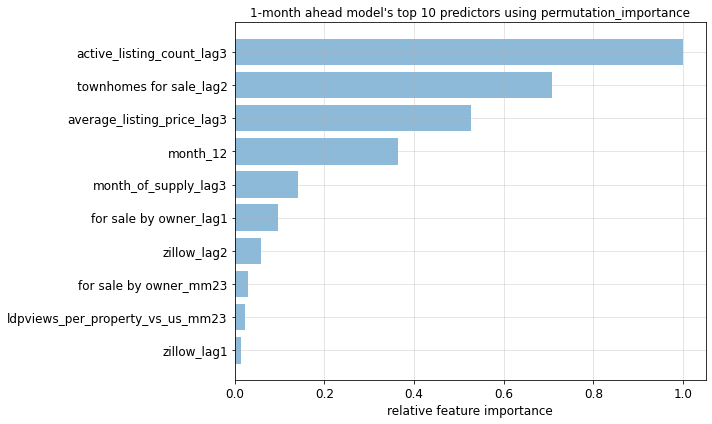

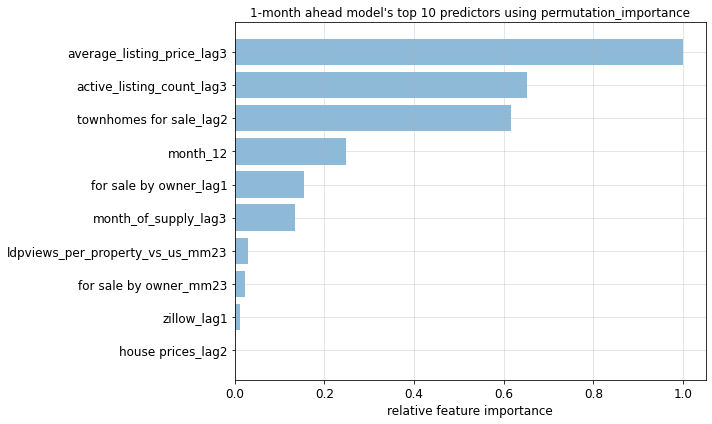

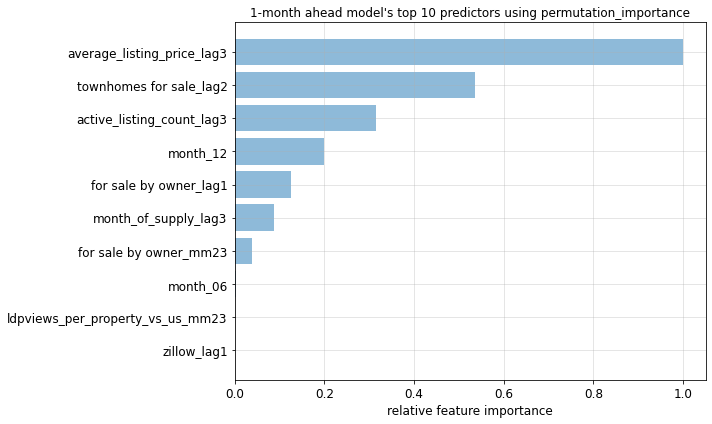

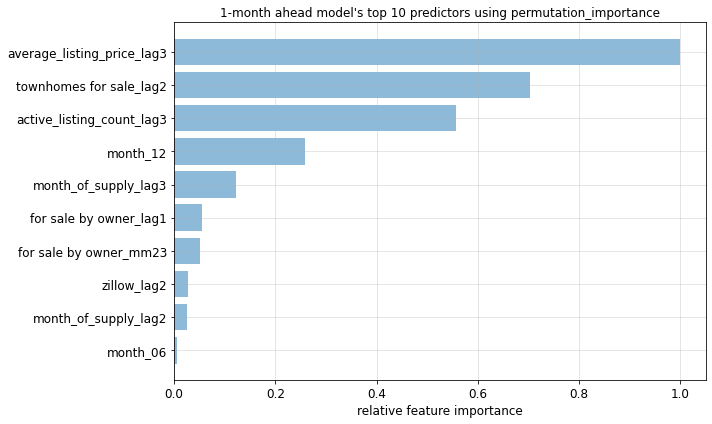

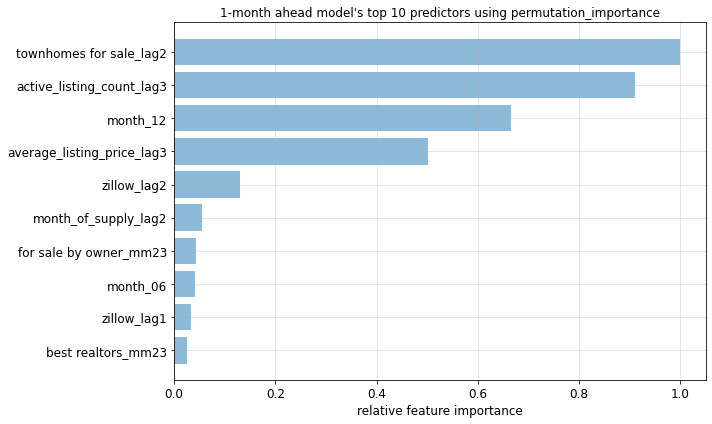

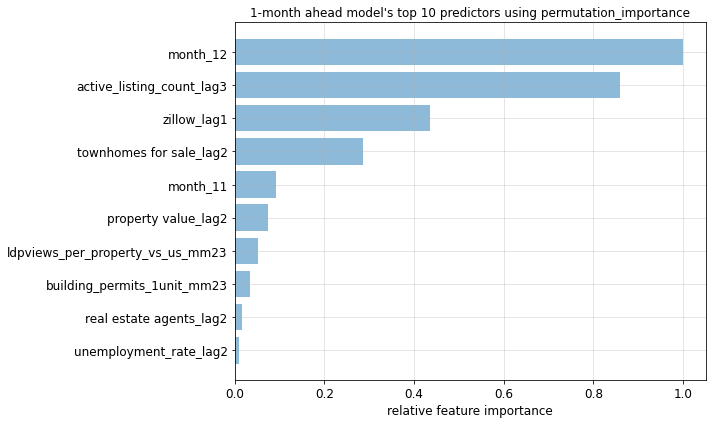

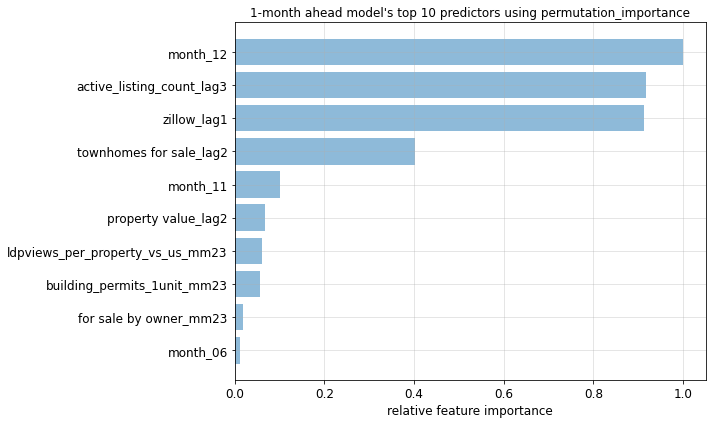

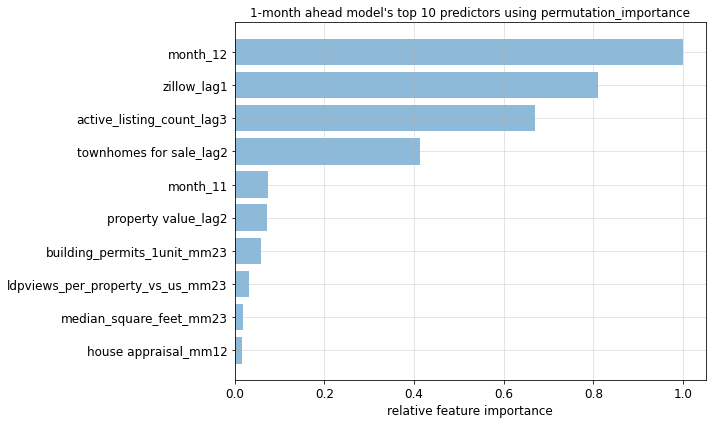

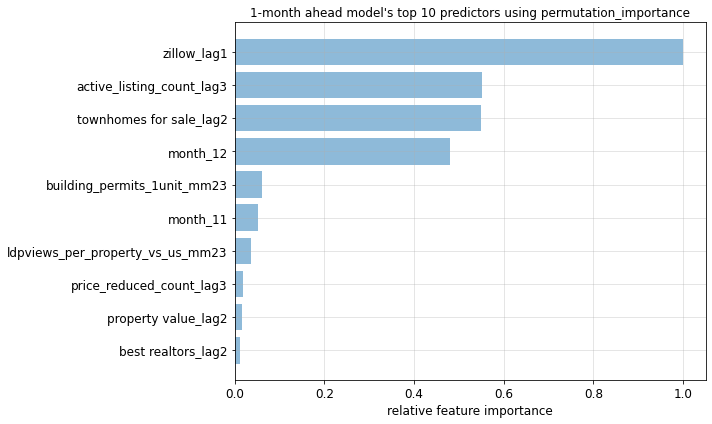

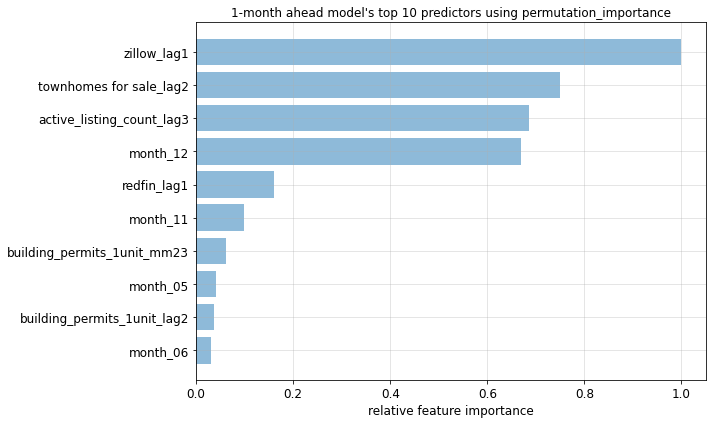

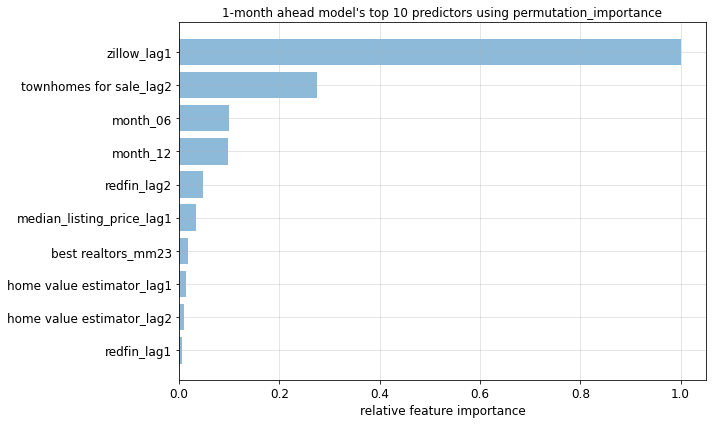

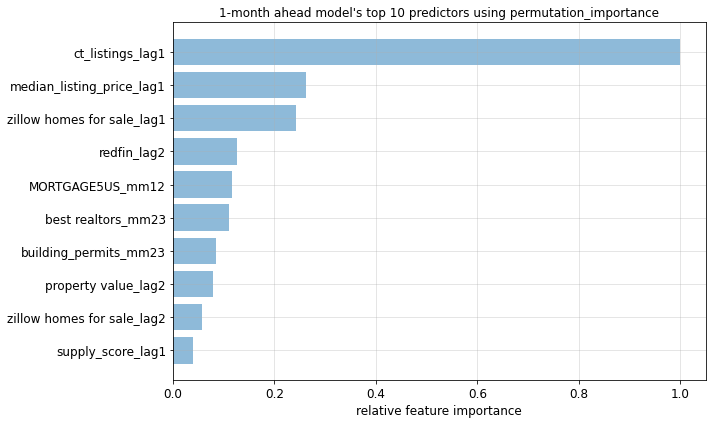

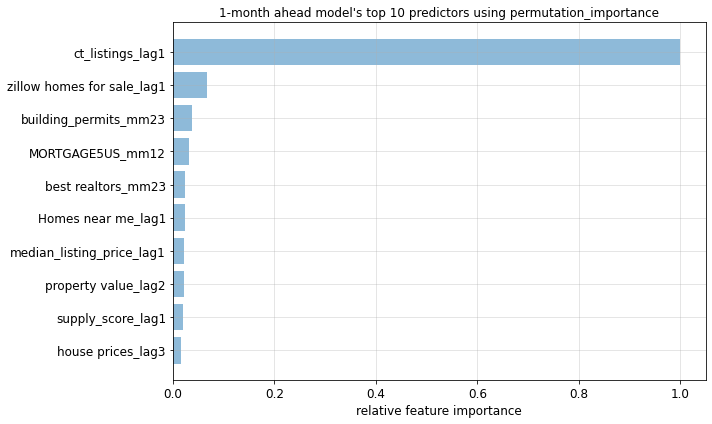

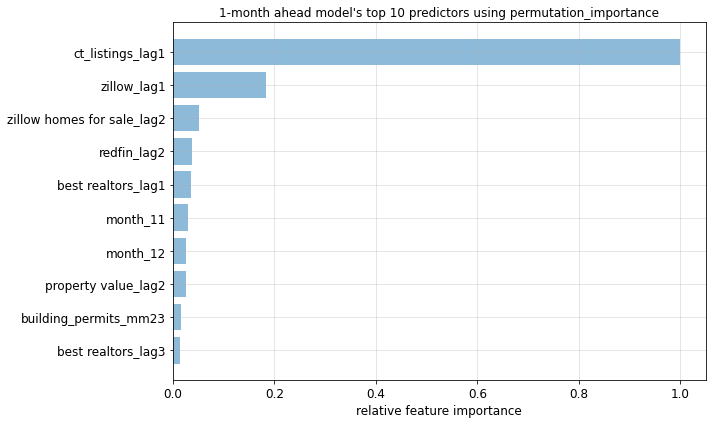

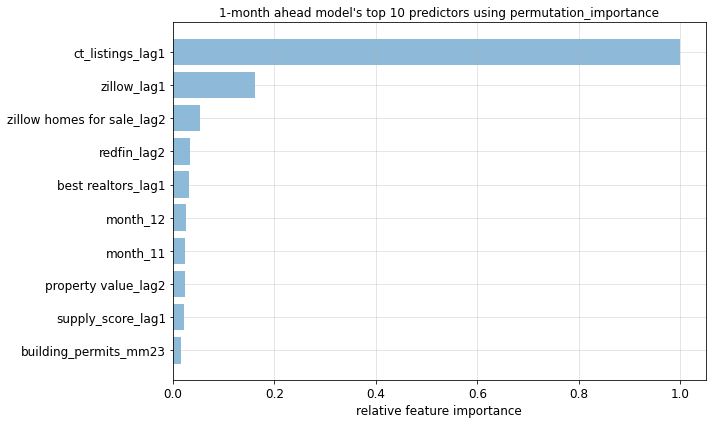

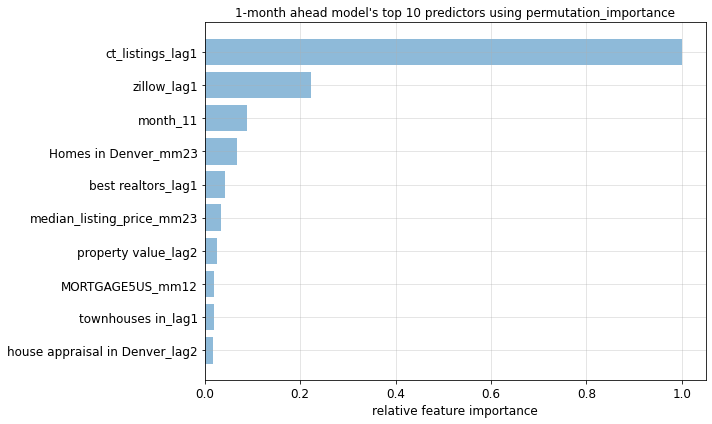

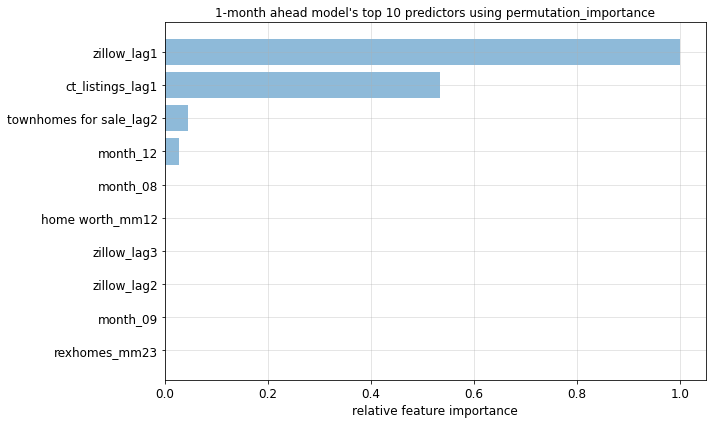

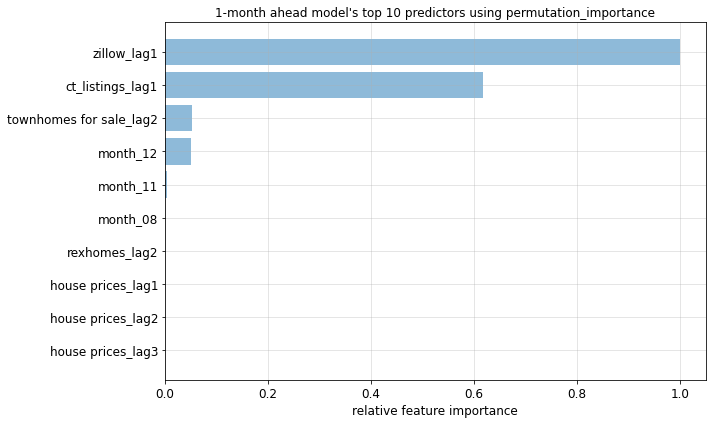

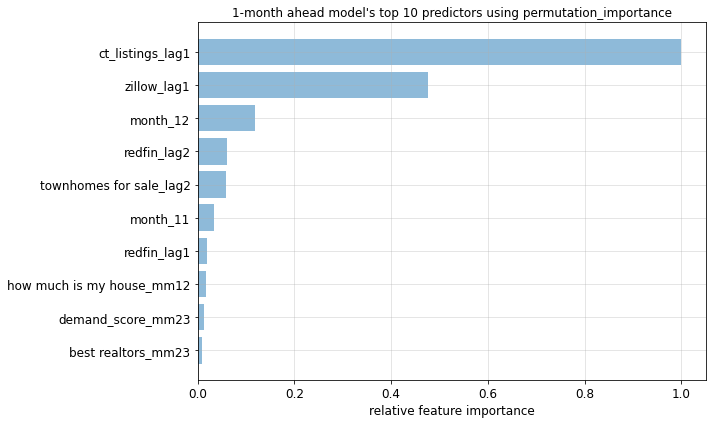

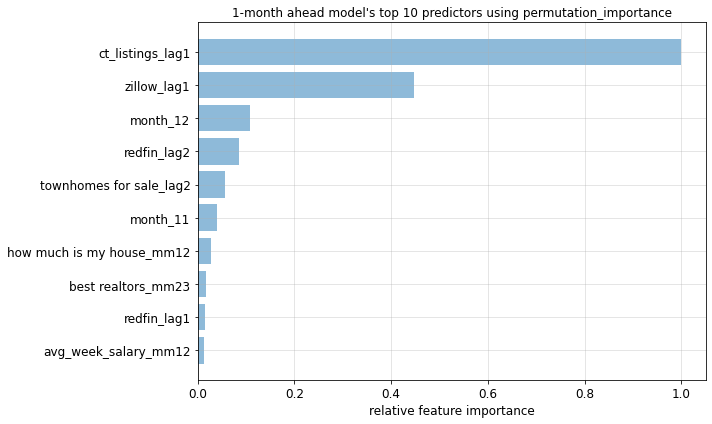

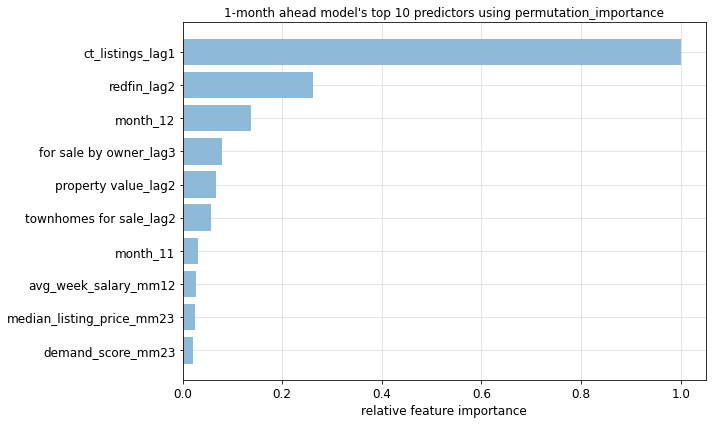

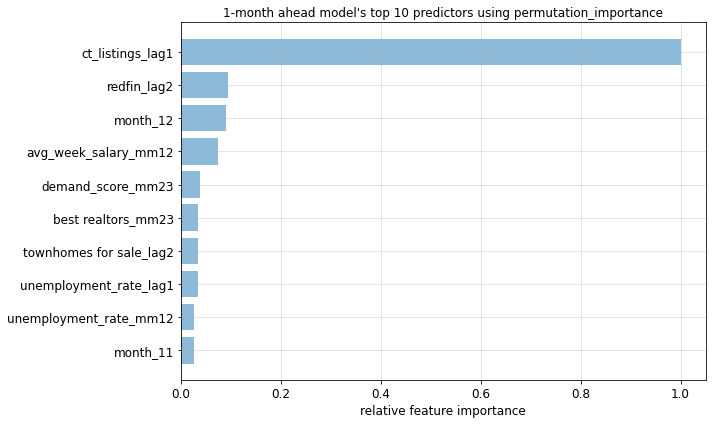

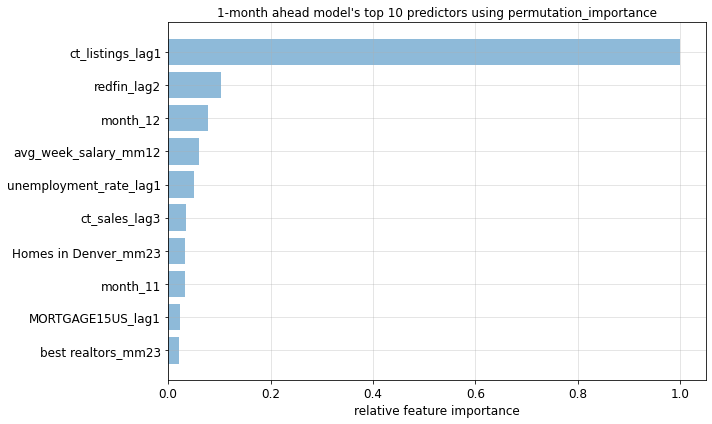

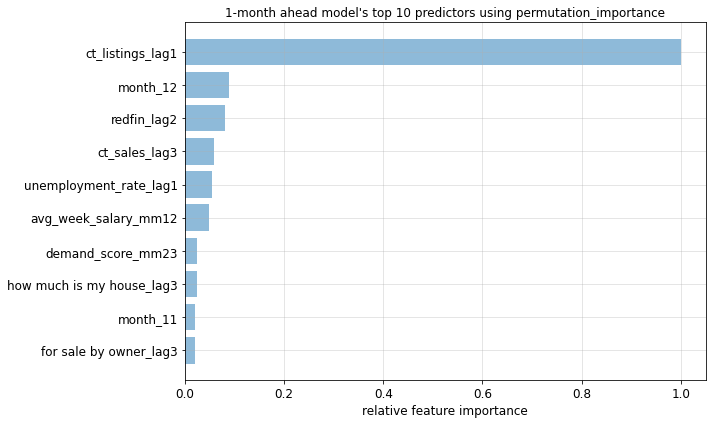

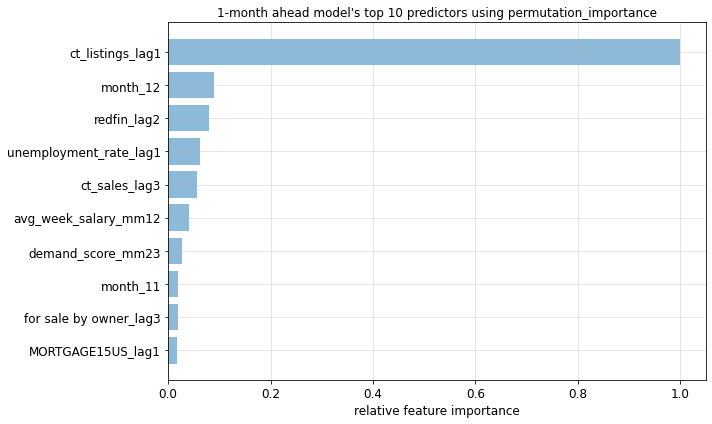

In [79]:
y_preds_1m = []
for i in range(len(df1) - start_idx):
    dft = df1.copy()
    train = dft.iloc[:start_idx+i]
    test = dft.iloc[[start_idx+i], :]
    
    X_train = train[feature_list]
    y_train = train[target].values

    X_test = test[feature_list]
    y_test = test[target].values
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
     
    reg_lasso_sale = LassoCV(n_alphas=1000, max_iter=10000, cv=5)
    reg_lasso_sale.fit(X_train, y_train)
    cal_permutation_importance(reg_lasso_sale, X_train, y_train, feature_list, 1)
    
    y_preds_1m.append(reg_lasso_sale.predict(X_test)[0])

In [80]:
y_true_1m = df1[target][-(len(df1)-start_idx):].values
print('y_true: ', y_true_1m)
print('y_pred: ', np.round(y_preds_1m).astype(int))
print('MAE: ', mean_absolute_error(y_true_1m, y_preds_1m))

y_true:  [ 5852  5427  3934  2242  4562  5153  6168  7605  9253 11413 13495 12281
 11373 10093  5688  2570  4538  4996  7365 11882 14457 14497 14812 13601
 12816]
y_pred:  [ 5836  5123  4449  2430  3137  4602  6303  7185  7618  8143  8212 10225
 14647 10141  8055  6740  4721  6765  7086  7396 11820 13391 13739 13644
 12355]
MAE:  1507.7698992451967


In [81]:
df.shape

(51, 54)

In [83]:
df

,month,ct_listings,ct_sales,homes for sale,townhomes for sale,Homes in,townhouses in,Homes near me,zillow homes for sale,selling a house,...,MORTGAGE15US,MORTGAGE30US,MORTGAGE5US,unemployment_rate,avg_hour_salary,avg_week_salary,building_permits,building_permits_1unit,month_of_supply,month_str
4,2016-07,8170,6408,61.815081,95.738568,84.635856,40.320925,4.728896,18.482621,61.552086,...,2.7475,3.4400,2.7500,3.1,28.895241,1002.485800,1557.790154,874.314620,1.134831,2016-07
5,2016-08,7697,6614,49.269667,55.532880,63.621405,82.316527,4.496565,16.339958,63.038638,...,2.7450,3.4350,2.7450,3.0,28.811627,1000.055202,1494.700070,913.006712,1.144088,2016-08
6,2016-09,6950,6109,38.933788,24.458258,42.838747,43.324917,8.171971,22.679009,42.922750,...,2.7560,3.4600,2.8140,2.9,28.719960,995.203511,1930.650955,906.829652,1.249141,2016-09
7,2016-10,5371,5599,28.381404,25.461185,39.078552,57.093753,3.720349,11.200653,16.765770,...,2.7625,3.4700,2.8275,2.8,29.187290,1031.379077,2442.475902,922.795686,1.312556,2016-10
8,2016-11,3966,5302,6.636020,14.200746,12.197739,26.952839,0.147016,0.000000,20.725690,...,3.0275,3.7700,2.9850,2.6,28.833690,997.094884,2349.575299,924.226980,1.200490,2016-11
9,2016-12,2768,5156,0.000000,29.493032,0.000000,59.916918,5.604900,2.500227,35.015561,...,3.4280,4.1980,3.2260,2.6,28.703273,991.628268,1451.485362,996.433042,0.949767,2016-12
10,2017-01,3990,3713,47.774894,49.558283,61.759908,32.358068,15.021557,20.903893,46.152678,...,3.3875,4.1500,3.2425,3.1,28.417102,1000.866403,2045.179237,754.082157,1.155131,2017-01
11,2017-02,4848,3586,46.652332,45.221664,75.118043,46.029160,13.096635,14.366095,45.370816,...,3.3800,4.1675,3.1950,2.9,28.483133,993.845379,2110.996346,899.120654,1.189347,2017-02
12,2017-03,7038,5444,58.237562,74.591176,71.118901,64.950721,20.866406,16.979762,99.367425,...,3.4140,4.1960,3.2140,2.7,28.336825,989.235931,2071.862298,946.871882,0.855070,2017-03
13,2017-04,6812,5356,58.262030,66.083080,75.661754,72.615460,17.544448,26.207460,76.278434,...,3.3000,4.0450,3.1475,2.5,28.635350,1019.382827,2370.696303,794.439087,0.983196,2017-04


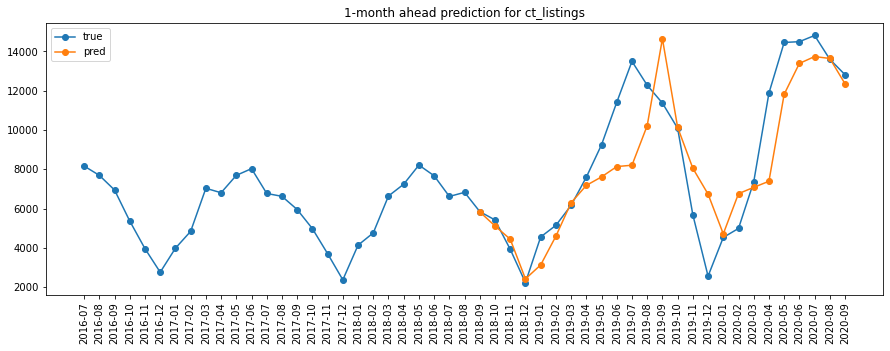

In [82]:
df['month_str'] = df['month'].apply(lambda x: str(x))

plt.figure(figsize=(15,5))
plt.title('1-month ahead prediction for {}'.format(target))
plt.plot(df['month_str'], df[target], label='true', marker='o')
plt.plot(df['month_str'][-(len(df1)-start_idx):], y_preds_1m, label='pred', marker='o')
plt.legend()

plt.xticks(rotation=90)
plt.show()

## Last 3-month Ahead

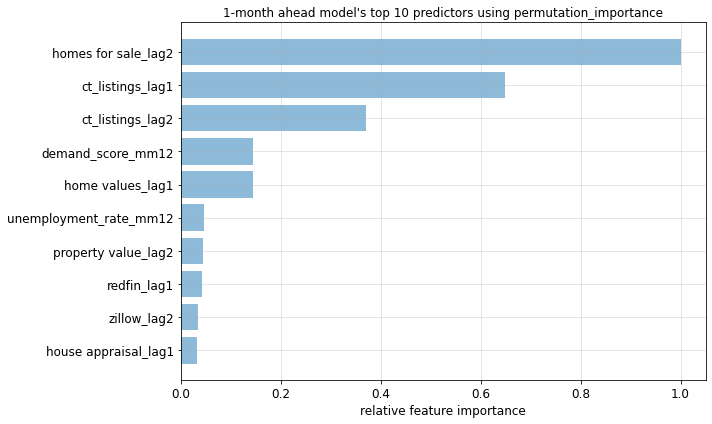

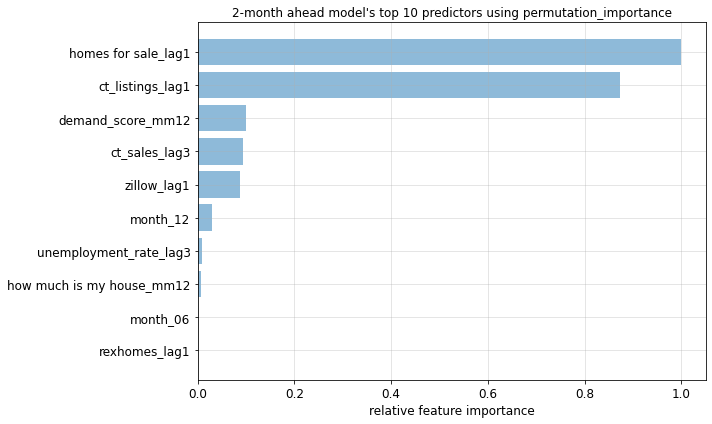

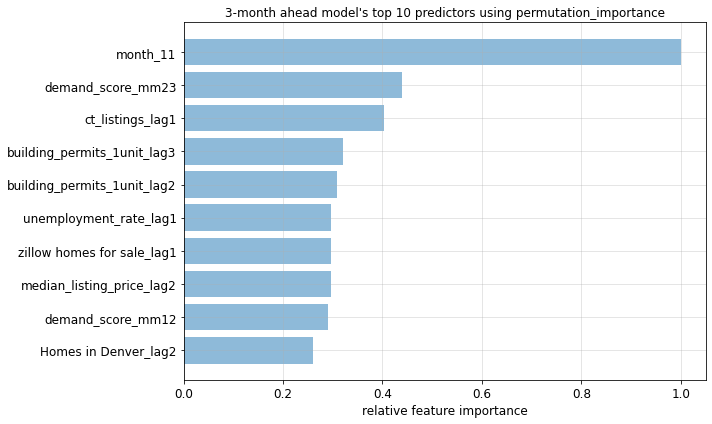

In [17]:
models = {}
y_preds = [] 
horizon = 3

for head in range(1, horizon+1):
    dft = df1.copy()
    dft[target] = dft[target].shift((-head+1))
    dft = dft.dropna()
    train = dft[:-horizon+head-1]
    test = dft[-horizon+head-1:].iloc[[0],:]
    
    X_train = train[feature_list]
    y_train = train[target].values

    X_test = test[feature_list]
    y_test = test[target].values
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #reg_lasso_sale = ElasticNetCV(l1_ratio=[0.05, .1, .2, .3, .4, .5, .6, .7, .8 ,.9, .95, .99, 1], max_iter=10000, cv=5)
    
    reg_lasso_sale = LassoCV(n_alphas=1000, max_iter=10000, cv=5)
    
    reg_lasso_sale.fit(X_train, y_train)
    cal_permutation_importance(reg_lasso_sale, X_train, y_train, feature_list, head)
    
    models[head] = reg_lasso_sale
    y_preds.append(reg_lasso_sale.predict(X_test)[0])
    

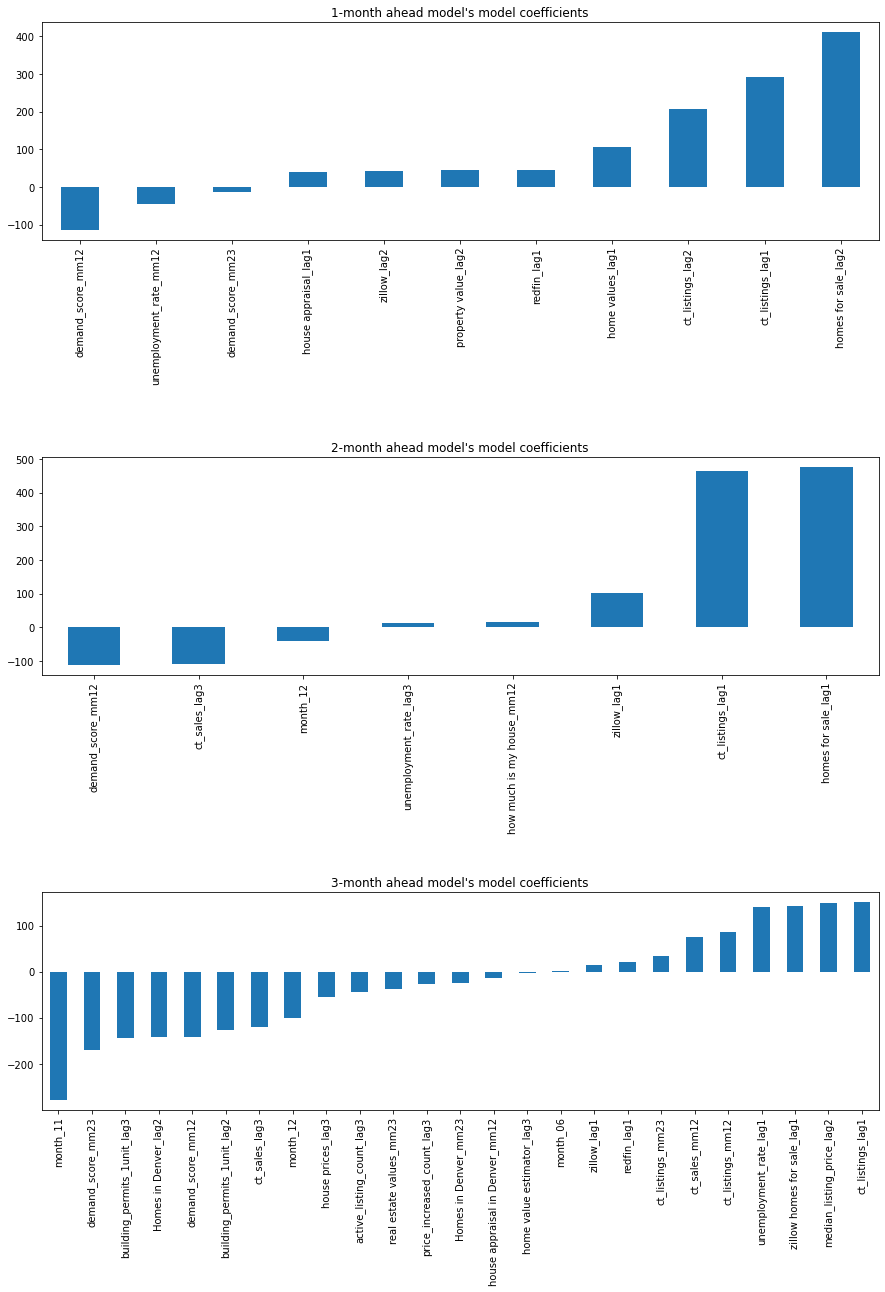

In [18]:
fig, axes = plt.subplots(horizon, 1, figsize=(15,20))
for head in range(1, horizon+1):
    coefs = pd.Series(models[head].coef_, index=feature_list).sort_values()
    select = coefs[coefs != 0]
    select.plot.bar(ax=axes[head-1])
    axes[head-1].set_title("{}-month ahead model's model coefficients".format(head))
plt.subplots_adjust(hspace=1)
plt.show()

In [19]:
y_true_3m = df1[target][-horizon:].values
print('y_true: ', y_true_3m)
print('y_pred: ', np.round(y_preds).astype(int))
print('MAE: ', mean_absolute_error(y_true_3m, y_preds))

y_true:  [9048 9080 8595]
y_pred:  [8402 9055 9462]
MAE:  512.4747863747525


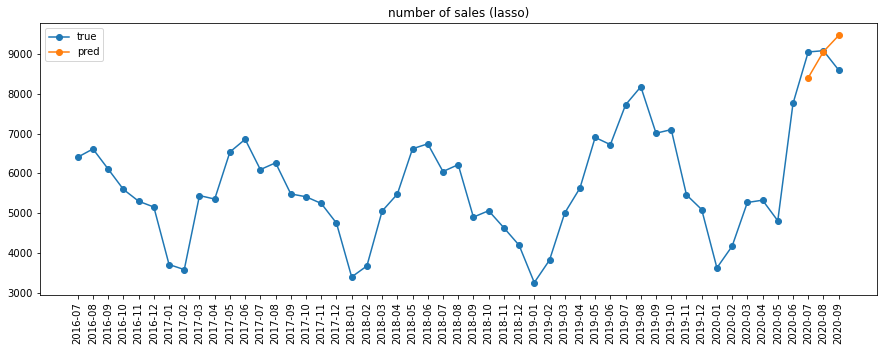

In [20]:
df['month_str'] = df['month'].apply(lambda x: str(x))

plt.figure(figsize=(15,5))
plt.title('number of sales (lasso)')
plt.plot(df['month_str'], df[target], label='true', marker='o')
plt.plot(df['month_str'][-horizon:], y_preds, label='pred', marker='o')
#plt.plot(df['month_str'][4:-6], y_pred_train1, label='pred on train', marker='o')
plt.legend()

plt.xticks(rotation=90)
plt.show()